# Understanding learning curves

Now that you’ve learned how to implement fine-tuning using both the Trainer API and custom training loops, it’s crucial to understand how to interpret the results. Learning curves are invaluable tools that help you evaluate your model’s performance during training and identify potential issues before they reduce performance.

In this section, we’ll explore how to read and interpret accuracy and loss curves, understand what different curve shapes tell us about our model’s behavior, and learn how to address common training issues.

## What are Learning Curves?
Learning curves are visual representations of your model’s performance metrics over time during training. The two most important curves to monitor are:

Loss curves: Show how the model’s error (loss) changes over training steps or epochs
Accuracy curves: Show the percentage of correct predictions over training steps or epochs
These curves help us understand whether our model is learning effectively and can guide us in making adjustments to improve performance. In Transformers, these metrics are individually computed for each batch and then logged to the disk. We can then use libraries like Weights & Biases to visualize these curves and track our model’s performance over time.

Loss Curves
The loss curve shows how the model’s error decreases over time. In a typical successful training run, you’ll see a curve similar to the one below:

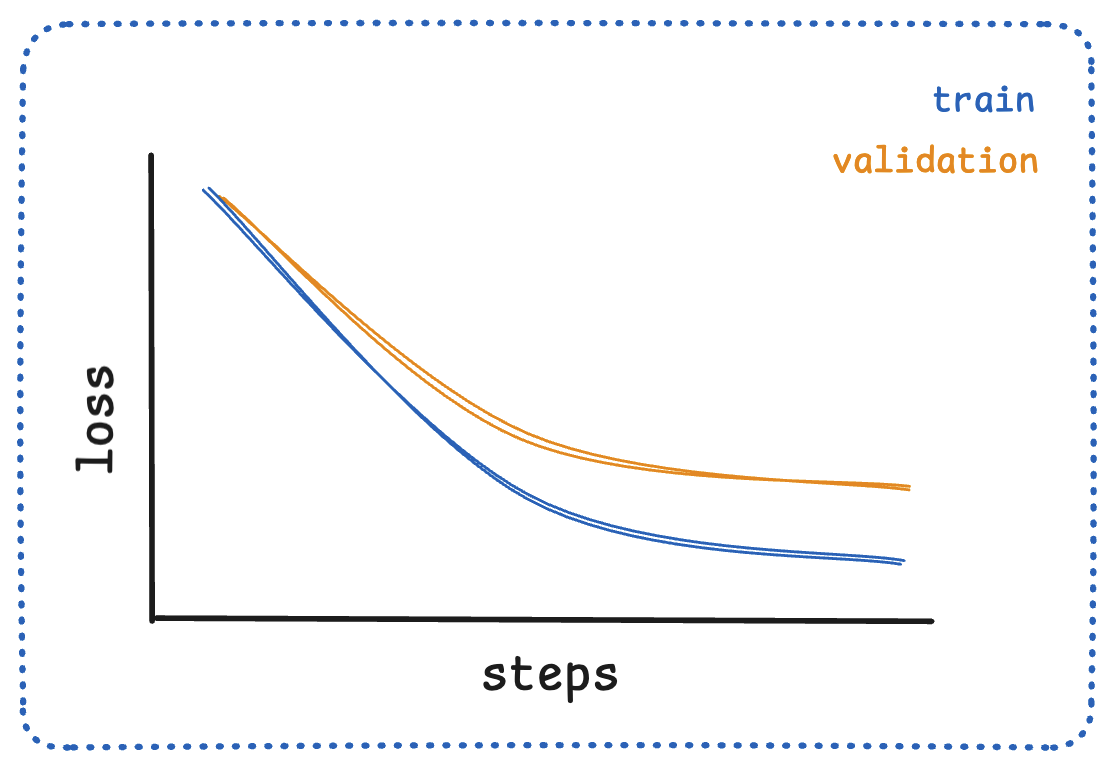

  High initial loss: The model starts without optimization, so predictions are initially poor

  Decreasing loss: As training progresses, the loss should generally decrease
  
  Convergence: Eventually, the loss stabilizes at a low value, indicating that the model has learned the patterns in the data

As in previous chapters, we can use the Trainer API to track these metrics and visualize them in a dashboard. Below is an example of how to do this with Weights & Biases.

In [ ]:
# Example of tracking loss during training with the Trainer
from transformers import Trainer, TrainingArguments
import wandb

# Initialize Weights & Biases for experiment tracking
wandb.init(project="transformer-fine-tuning", name="bert-mrpc-analysis")

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=50,
    save_steps=100,
    logging_steps=10,  # Log metrics every 10 steps
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    report_to="wandb",  # Send logs to Weights & Biases
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

# Train and automatically log metrics
trainer.train()

## Accuracy Curves
The accuracy curve shows the percentage of correct predictions over time. Unlike loss curves, accuracy curves should generally increase as the model learns and can typically include more steps than the loss curve.

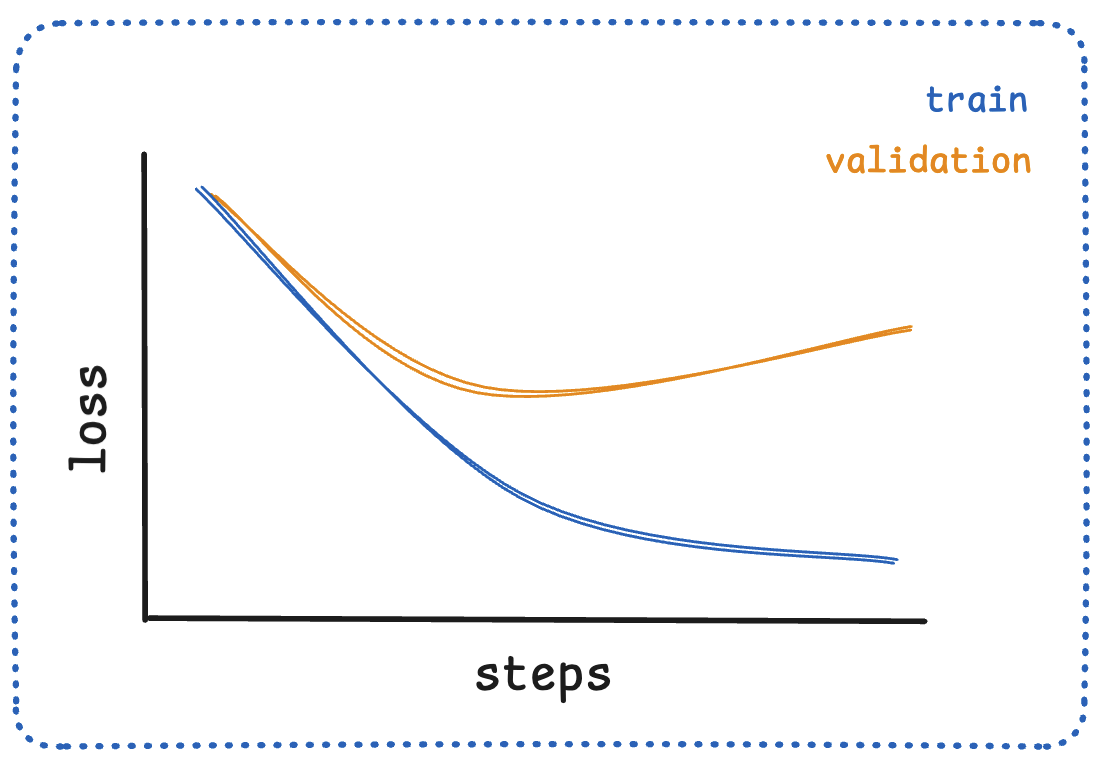

  Start low: Initial accuracy should be low, as the model has not yet learned the patterns in the data

  Increase with training: Accuracy should generally improve as the model learns if it is able to learn the patterns in the data

  May show plateaus: Accuracy often increases in discrete jumps rather than smoothly, as the model makes predictions that are close to the true labels

💡 Why Accuracy Curves Are “Steppy”: Unlike loss, which is continuous, accuracy is calculated by comparing discrete predictions to true labels. Small improvements in model confidence might not change the final prediction, causing accuracy to remain flat until a threshold is crossed.

### Convergence
Convergence occurs when the model’s performance stabilizes and the loss and accuracy curves level off. This is a sign that the model has learned the patterns in the data and is ready to be used. In simple terms, we are aiming for the model to converge to a stable performance every time we train it.



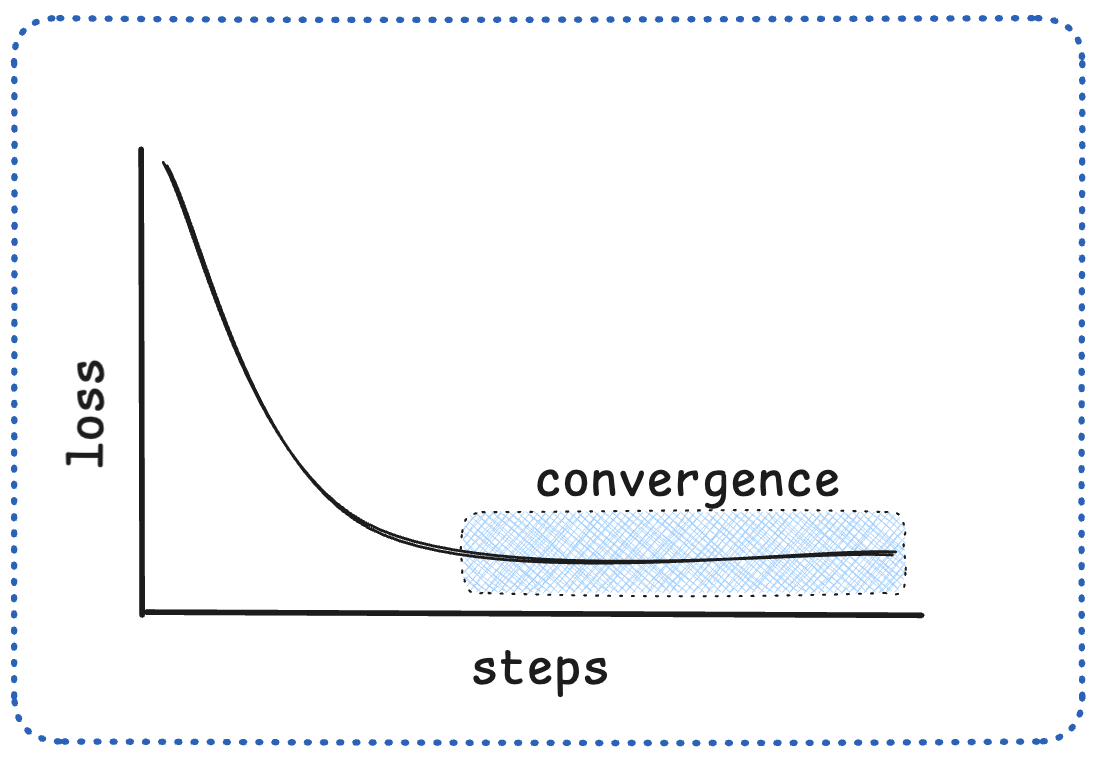

Once models have converged, we can use them to make predictions on new data and refer to evaluation metrics to understand how well the model is performing.

## Interpreting Learning Curve Patterns
Different curve shapes reveal different aspects of your model’s training. Let’s examine the most common patterns and what they mean.

### Healthy Learning Curves
A well-behaved training run typically shows curve shapes similar to the one below:

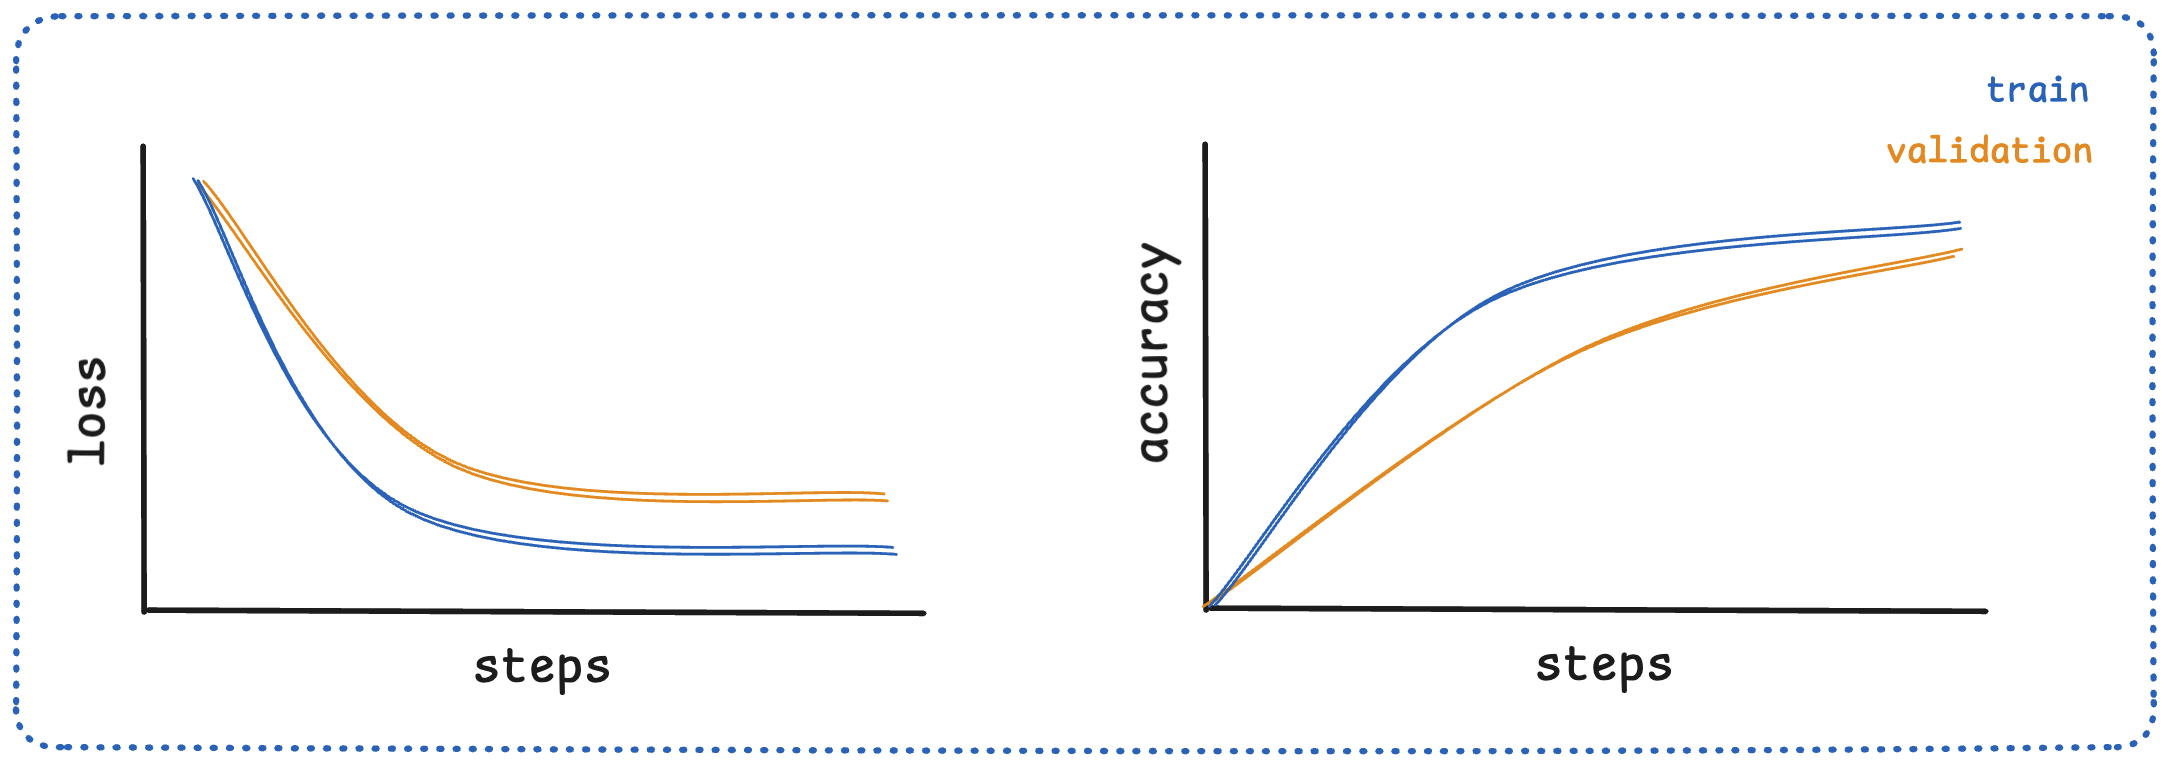

Let’s look at the illustration above. It displays both the loss curve (on the left) and the corresponding accuracy curve (on the right). These curves have distinct characteristics.

The loss curve shows the value of the model’s loss over time. Initially, the loss is high and then it gradually decreases, indicating that the model is improving. A decrease in the loss value suggests that the model is making better predictions, as the loss represents the error between the predicted output and the true output.

Now let’s shift our focus to the accuracy curve. It represents the model’s accuracy over time. The accuracy curve begins at a low value and increases as training progresses. Accuracy measures the proportion of correctly classified instances. So, as the accuracy curve rises, it signifies that the model is making more correct predictions.

One notable difference between the curves is the smoothness and the presence of “plateaus” on the accuracy curve. While the loss decreases smoothly, the plateaus on the accuracy curve indicate discrete jumps in accuracy instead of a continuous increase. This behavior is attributed to how accuracy is measured. The loss can improve if the model’s output gets closer to the target, even if the final prediction is still incorrect. Accuracy, however, only improves when the prediction crosses the threshold to be correct.

For example, in a binary classifier distinguishing cats (0) from dogs (1), if the model predicts 0.3 for an image of a dog (true value 1), this is rounded to 0 and is an incorrect classification. If in the next step it predicts 0.4, it’s still incorrect. The loss will have decreased because 0.4 is closer to 1 than 0.3, but the accuracy remains unchanged, creating a plateau. The accuracy will only jump up when the model predicts a value greater than 0.5 that gets rounded to 1.

#### Characteristics of healthy curves:

  Smooth decline in loss: Both training and validation loss decrease steadily

  Close training/validation performance: Small gap between training and validation metrics

  Convergence: Curves level off, indicating the model has learned the patterns

## Practical Examples
Let’s work through some practical examples of learning curves. First, we will highlight some approaches to monitor the learning curves during training. Below, we will break down the different patterns that can be observed in the learning curves.

### During Training
During the training process (after you’ve hit trainer.train()), you can monitor these key indicators:

  Loss convergence: Is the loss still decreasing or has it plateaued?
  
  Overfitting signs: Is validation loss starting to increase while training loss decreases?
  
  Learning rate: Are the curves too erratic (LR too high) or too flat (LR too low)?
  
  Stability: Are there sudden spikes or drops that indicate problems?
  
### After Training
After the training process is complete, you can analyze the complete curves to understand the model’s performance.

  Final performance: Did the model reach acceptable performance levels?
  
  Efficiency: Could the same performance be achieved with fewer epochs?
  
  Generalization: How close are training and validation performance?

Trends: Would additional training likely improve performance?
🔍 W&B Dashboard Features: Weights & Biases automatically creates beautiful, interactive plots of your learning curves. You can:

  Compare multiple runs side by side
  
  Add custom metrics and visualizations
  
  Set up alerts for anomalous behavior
  
  Share results with your team
  
  Learn more in the Weights & Biases documentation.

### overfitting
Overfitting occurs when the model learns too much from the training data and is unable to generalize to different data (represented by the validation set).



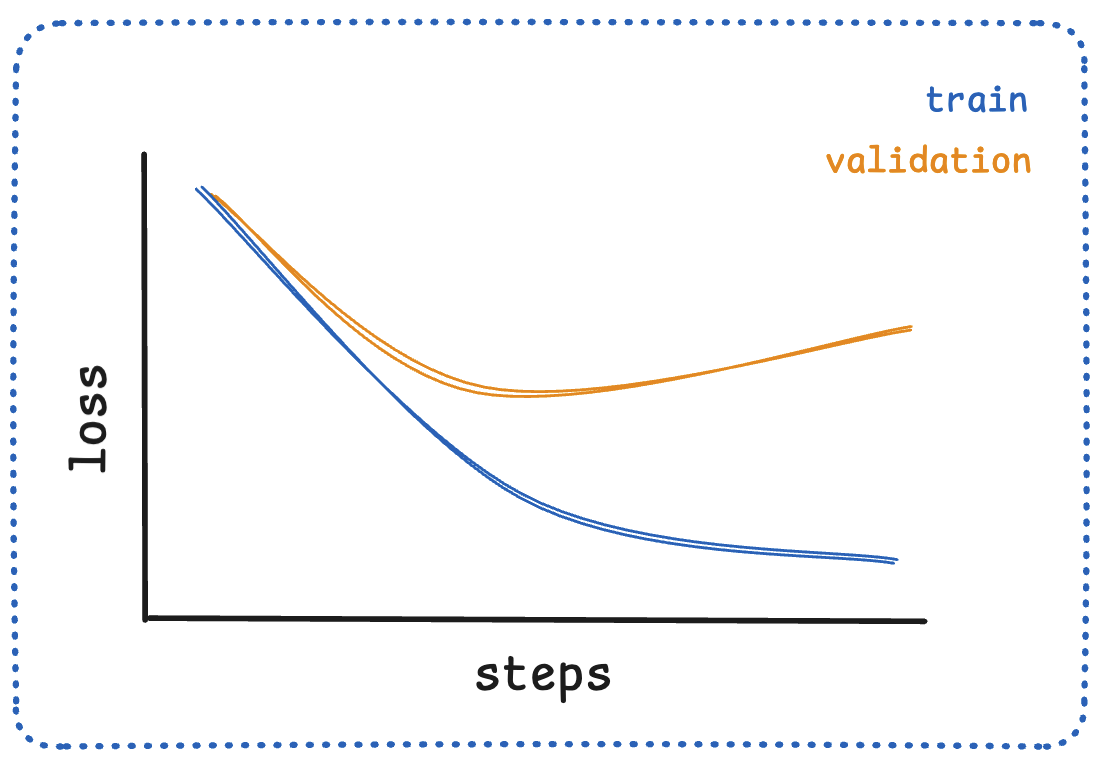

#### Symptoms:

Training loss continues to decrease while validation loss increases or plateaus

Large gap between training and validation accuracy

Training accuracy much higher than validation accuracy

#### Solutions for overfitting:

Regularization: Add dropout, weight decay, or other regularization techniques

Early stopping: Stop training when validation performance stops improving

Data augmentation: Increase training data diversity

Reduce model complexity: Use a smaller model or fewer parameters


In the sample below, we use early stopping to prevent overfitting. We set the early_stopping_patience to 3, which means that if the validation loss does not improve for 3 consecutive epochs, the training will be stopped.

In [ ]:
# Example of detecting overfitting with early stopping
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    num_train_epochs=10,  # Set high, but we'll stop early
)

# Add early stopping to prevent overfitting
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

### 2. Underfitting
Underfitting occurs when the model is too simple to capture the underlying patterns in the data. This can happen for several reasons:

  The model is too small or lacks capacity to learn the patterns
  
  The learning rate is too low, causing slow learning
  
  The dataset is too small or not representative of the problem
  
  The model is not properly regularized

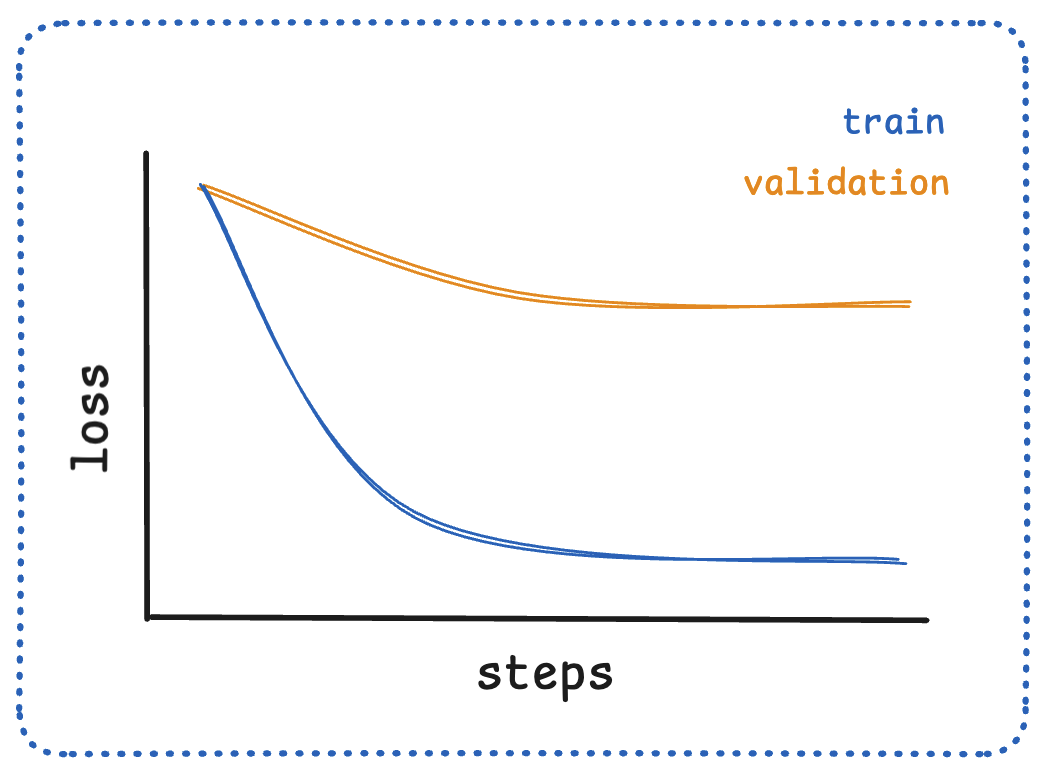

#### Symptoms:

  Both training and validation loss remain high
  
  Model performance plateaus early in training
  
  Training accuracy is lower than expected

#### Solutions for underfitting:

  Increase model capacity: Use a larger model or more parameters
  
  Train longer: Increase the number of epochs
  
  Adjust learning rate: Try different learning rates
  
  Check data quality: Ensure your data is properly preprocessed

In the sample below, we train for more epochs to see if the model can learn the patterns in the data.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    -num_train_epochs=5,
    +num_train_epochs=10,
)

### 3. Erratic Learning Curves
Erratic learning curves occur when the model is not learning effectively. This can happen for several reasons:

  The learning rate is too high, causing the model to overshoot the optimal parameters
  
  The batch size is too small, causing the model to learn slowly
  
  The model is not properly regularized, causing it to overfit to the training data
  
  The dataset is not properly preprocessed, causing the model to learn from noise


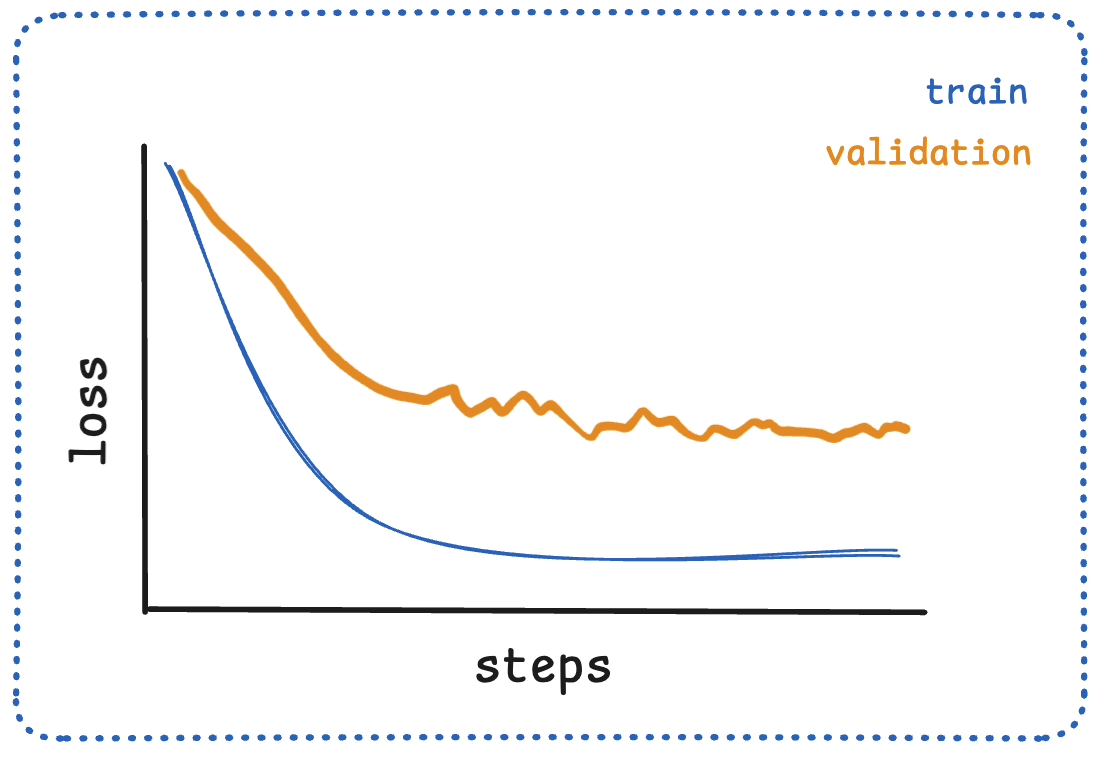

#### Symptoms:

Frequent fluctuations in loss or accuracy

Curves show high variance or instability

Performance oscillates without clear trend

Both training and validation curves show erratic behavior.



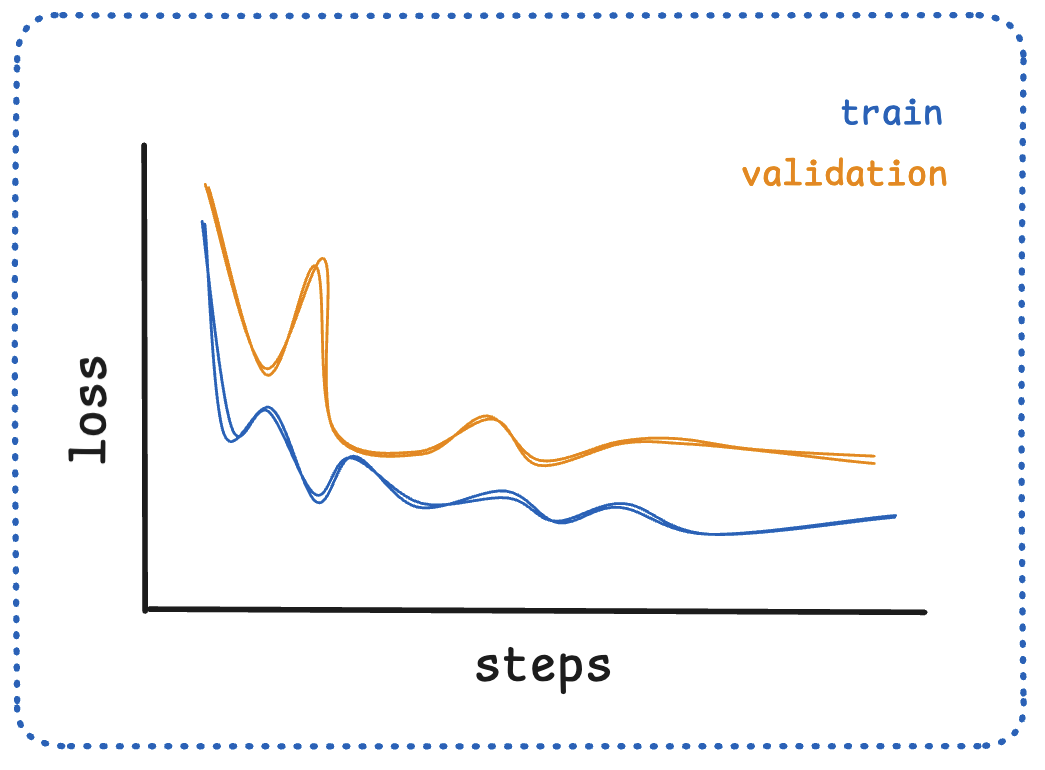

#### Solutions for erratic curves:

  Lower learning rate: Reduce step size for more stable training
  
  Increase batch size: Larger batches provide more stable gradients
  
  Gradient clipping: Prevent exploding gradients
  
  Better data preprocessing: Ensure consistent data quality

In the sample below, we lower the learning rate and increase the batch size.



In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    -learning_rate=1e-5,
    +learning_rate=1e-4,
    -per_device_train_batch_size=16,
    +per_device_train_batch_size=32,
)

## Key Takeaways
Understanding learning curves is crucial for becoming an effective machine learning practitioner. These visual tools provide immediate feedback about your model’s training progress and help you make informed decisions about when to stop training, adjust hyperparameters, or try different approaches. With practice, you’ll develop an intuitive understanding of what healthy learning curves look like and how to address issues when they arise.

💡 Key Takeaways:

  Learning curves are essential tools for understanding model training progress
  
  Monitor both loss and accuracy curves, but remember they have different characteristics
  
  Overfitting shows as diverging training/validation performance
  
  Underfitting shows as poor performance on both training and validation data
  
  Tools like Weights & Biases make it easy to track and analyze learning curves
  
  Early stopping and proper regularization can address most common training issues


🔬 Next Steps: Practice analyzing learning curves on your own fine-tuning experiments. Try different hyperparameters and observe how they affect the curve shapes. This hands-on experience is the best way to develop intuition for reading training progress.